In [1]:
import numpy as np
import pandas as pd
from plotnine import *

from vtreat.partial_pooling_estimator import pooled_effect_estimate, standard_effect_estimate


In [2]:
rng = np.random.default_rng(2024)

In [3]:
d = pd.DataFrame({
    'location_id': rng.choice([
        f'loc_{i}' for i in range(200)],
        size=400,
        replace=True)
})
d['observation'] = rng.binomial(n=1, p=0.5, size=d.shape[0])
d

,location_id,observation
0,loc_48,1
1,loc_135,1
2,loc_18,1
3,loc_42,1
4,loc_63,1
...,...,...
395,loc_190,0
396,loc_133,1
397,loc_39,0
398,loc_38,0


In [4]:
r = standard_effect_estimate(d)

r

,location_id,mean,var,size,estimate,grand_mean,impact
0,loc_0,0.500000,0.500000,2,0.500000,0.5325,-0.032500
1,loc_1,0.250000,0.250000,4,0.250000,0.5325,-0.282500
2,loc_10,0.666667,0.333333,3,0.666667,0.5325,0.134167
3,loc_101,0.000000,0.000000,3,0.000000,0.5325,-0.532500
4,loc_102,1.000000,NaN,1,1.000000,0.5325,0.467500
...,...,...,...,...,...,...,...
172,loc_94,0.000000,NaN,1,0.000000,0.5325,-0.532500
173,loc_95,0.000000,NaN,1,0.000000,0.5325,-0.532500
174,loc_96,1.000000,NaN,1,1.000000,0.5325,0.467500
175,loc_97,0.625000,0.267857,8,0.625000,0.5325,0.092500


In [5]:
r.loc[
    (r['impact'] >= np.max(r['impact']))
    | (r['impact'] <= np.min(r['impact'])),
    :]

,location_id,mean,var,size,estimate,grand_mean,impact
3,loc_101,0.0,0.0,3,0.0,0.5325,-0.5325
4,loc_102,1.0,NaN,1,1.0,0.5325,0.4675
6,loc_105,1.0,NaN,1,1.0,0.5325,0.4675
10,loc_11,1.0,NaN,1,1.0,0.5325,0.4675
12,loc_111,0.0,0.0,2,0.0,0.5325,-0.5325
...,...,...,...,...,...,...,...
164,loc_85,0.0,NaN,1,0.0,0.5325,-0.5325
170,loc_92,1.0,NaN,1,1.0,0.5325,0.4675
172,loc_94,0.0,NaN,1,0.0,0.5325,-0.5325
173,loc_95,0.0,NaN,1,0.0,0.5325,-0.5325


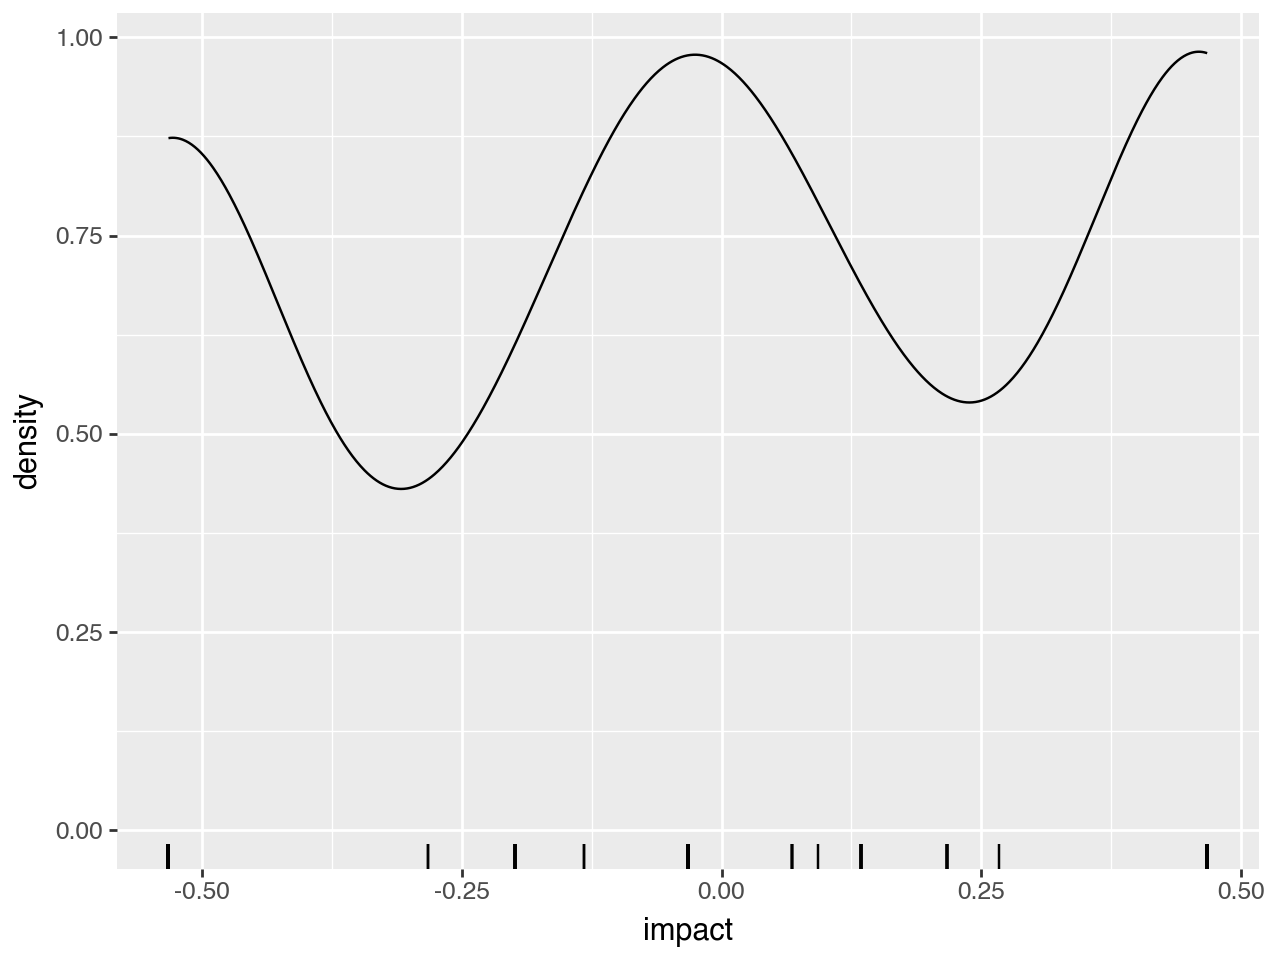

In [6]:
(
    ggplot(
        data=r,
        mapping=aes(x='impact'),
    )
    + geom_density()
    + geom_rug()
)

In [7]:
r2 = pooled_effect_estimate(d)

r2

,location_id,mean,var,size,estimate,grand_mean,impact
0,loc_0,0.500000,0.500000,2,0.519000,0.5325,-0.013500
1,loc_1,0.250000,0.250000,4,0.333864,0.5325,-0.198636
2,loc_10,0.666667,0.333333,3,0.611252,0.5325,0.078752
3,loc_101,0.000000,0.000000,3,0.065500,0.5325,-0.467000
4,loc_102,1.000000,NaN,1,0.786364,0.5325,0.253864
...,...,...,...,...,...,...,...
172,loc_94,0.000000,NaN,1,0.243339,0.5325,-0.289161
173,loc_95,0.000000,NaN,1,0.243339,0.5325,-0.289161
174,loc_96,1.000000,NaN,1,0.786364,0.5325,0.253864
175,loc_97,0.625000,0.267857,8,0.608035,0.5325,0.075535


In [8]:
r2.loc[
    (r2['impact'] >= np.max(r2['impact']))
    | (r2['impact'] <= np.min(r2['impact'])),
    :]

,location_id,mean,var,size,estimate,grand_mean,impact
41,loc_14,1.0,0.0,5,0.975165,0.5325,0.442665
65,loc_165,0.0,0.0,5,0.028288,0.5325,-0.504212
155,loc_74,1.0,0.0,5,0.975165,0.5325,0.442665


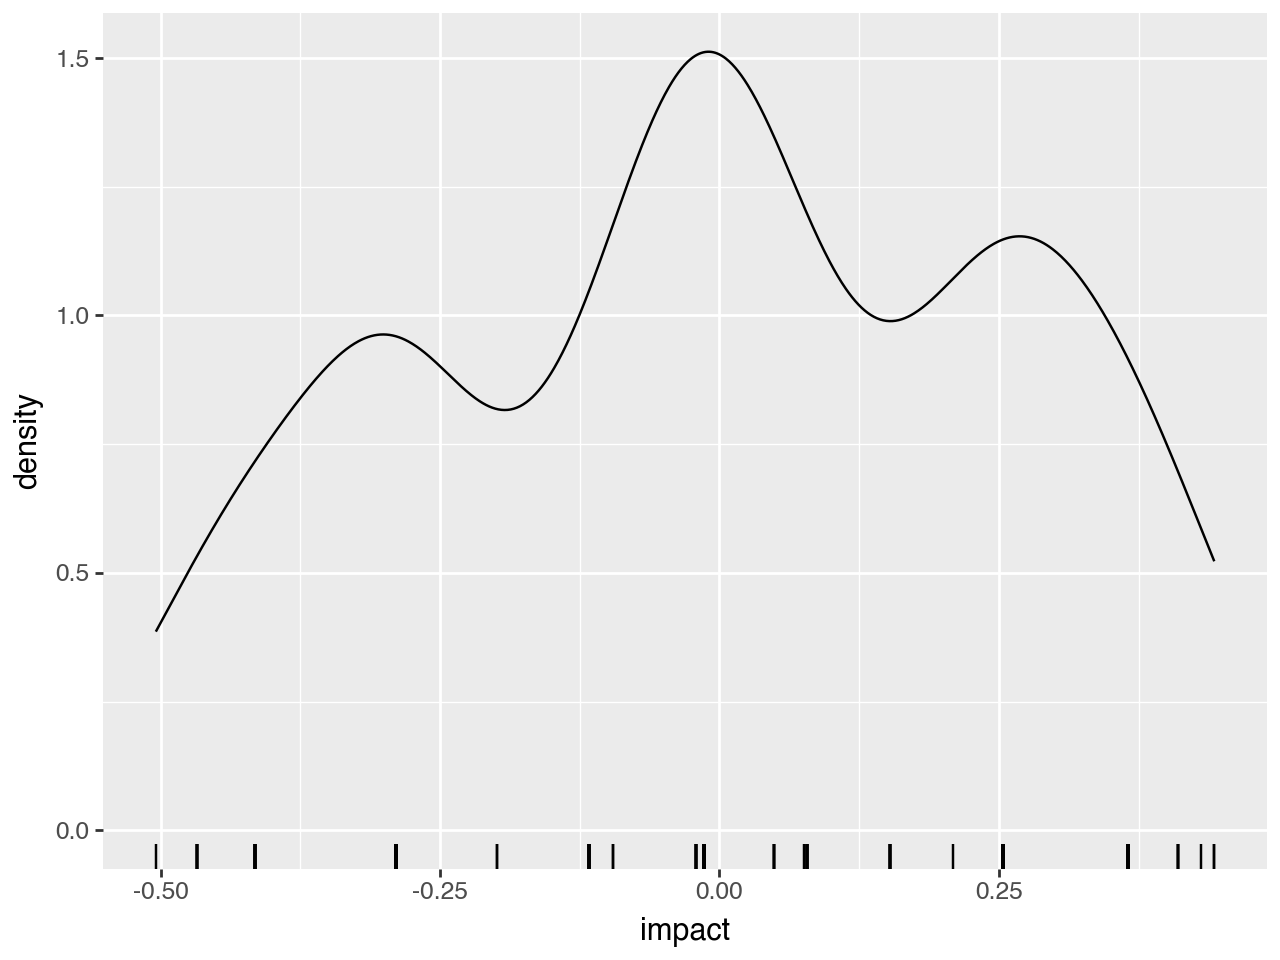

In [9]:
(
    ggplot(
        data=r2,
        mapping=aes(x='impact'),
    )
    + geom_density()
    + geom_rug()
)